In [66]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [67]:
from google.colab import drive

# This will prompt for authorization.
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
googlepath = "/content/drive/My Drive/Colab Notebooks/SeniorDesignGAN/MiloGAN/"

# Setting the Training Amount
TRAINING_AMOUNT = 50000 # low to test for now
SAVE_STEPS_AMOUNT = 10000 # testing for now
PCT_CHANGE_AMOUNT = 5 # just want to see up down trends
HISTORICAL_DAYS_AMOUNT = 20
DAYS_AHEAD = 5

In [0]:
#Getting the Data

In [70]:
'''
Downloads stock data from alphavantage
'''
import pandas as pd 
import os
import time
import urllib
import json
import csv
import requests
import io
from pathlib import Path
import random

ALPHA_VANTAGE_KEY = "CDRQTN7OC8V8TPKD"

'''
Note should have companylist.csv in the directory with this file.
'''

'''
Saves data to a file
'''
def save(googlepath, stock_csv, output_dir, filename):
    try:
        #the output dir may not exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
    except Exception as ex:
        print('Could not create output dir')
        print(ex)
        return
    filepath = os.path.join(googlepath, output_dir, filename)
    try:
#         print(stock_csv)
        df = stock_csv
        df = df.sort_values(by='timestamp')  
#         print(df)
        df.to_csv(filepath, index=False)
    except Exception as ex:
        print('Could not open file {} to write data'.format(filepath))
        print(ex)


def try_download(symbol):
    try:
        # Keep call frequency below threshold 
        time.sleep(12)    
        url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&apikey={}&datatype=csv&outputsize=full'.format(symbol, ALPHA_VANTAGE_KEY)
        c = pd.read_csv(url)
        # getting rid of some columns won't look at for now
        c = c.drop(['split_coefficient', 'dividend_amount', 'adjusted_close'], axis=1)
        return c, True
    except Exception as ex:
        print(ex)
        return None, None



#Given a stock symbol (aka 'tsla') will download and save the data to the
#output dir as a csv 

def download_symbol(symbol, output_dir, retry_count=4):

    stock_csv, didPass = try_download(symbol)
    if didPass:
        save(googlepath, stock_csv, output_dir, '{}.csv'.format(symbol))
    else:
        print('Failed to download {}'.format(symbol))

df = pd.read_csv(f"{googlepath}companylist.csv")
# df = df.sort_values(by=['MarketCap'], ascending=False)
# Top 30 Companies
# df = df[:30]
for symbol in df.Symbol:
    my_file = Path(f"{googlepath}stock_data/{symbol}.csv")  # check if already downloaded
#     print(my_file.exists())
    if not my_file.exists():
        print('Downloading {}'.format(symbol))
        download_symbol(symbol, 'stock_data')
    else:
        print(f"Already downloaded {symbol}")


In [0]:
#plot confusion matrices
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

SEED = 42
tf.set_random_seed(SEED)

class GAN():

    def sample_Z(self, batch_size, n):
        return np.random.uniform(-1., 1., size=(batch_size, n))

    def __init__(self, num_features, num_historical_days, generator_input_size=200, is_train=True):
        def get_batch_norm_with_global_normalization_vars(size):
            v = tf.Variable(tf.ones([size]), dtype=tf.float32)
            m = tf.Variable(tf.ones([size]), dtype=tf.float32)
            beta = tf.Variable(tf.ones([size]), dtype=tf.float32)
            gamma = tf.Variable(tf.ones([size]), dtype=tf.float32)
            return v, m, beta, gamma

        self.X = tf.placeholder(tf.float32, shape=[None, num_historical_days, num_features])
        X = tf.reshape(self.X, [-1, num_historical_days, 1, num_features])
        self.Z = tf.placeholder(tf.float32, shape=[None, generator_input_size])

        generator_output_size = num_features*num_historical_days
        with tf.variable_scope("generator"):
            W1 = tf.Variable(tf.truncated_normal([generator_input_size, generator_output_size*10]))
            b1 = tf.Variable(tf.truncated_normal([generator_output_size*10]))

            h1 = tf.nn.sigmoid(tf.matmul(self.Z, W1) + b1)

            # v1, m1, beta1, gamma1 = get_batch_norm_with_global_normalization_vars(generator_output_size*10)
            # h1 = tf.nn.batch_norm_with_global_normalization(h1, v1, m1,
            #         beta1, gamma1, variance_epsilon=0.000001, scale_after_normalization=False)

            W2 = tf.Variable(tf.truncated_normal([generator_output_size*10, generator_output_size*5]))
            b2 = tf.Variable(tf.truncated_normal([generator_output_size*5]))

            h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2)

            # v2, m2, beta2, gamma2 = get_batch_norm_with_global_normalization_vars(generator_output_size*5)
            # h2 = tf.nn.batch_norm_with_global_normalization(h2, v2, m2,
            #         beta2, gamma2, variance_epsilon=0.000001, scale_after_normalization=False)


            W3 = tf.Variable(tf.truncated_normal([generator_output_size*5, generator_output_size]))
            b3 = tf.Variable(tf.truncated_normal([generator_output_size]))

            g_log_prob = tf.matmul(h2, W3) + b3
            g_log_prob = tf.reshape(g_log_prob, [-1, num_historical_days, 1, num_features])
            self.gen_data = tf.reshape(g_log_prob, [-1, num_historical_days, num_features])
            #g_log_prob = g_log_prob / tf.reshape(tf.reduce_max(g_log_prob, axis=1), [-1, 1, num_features, 1])
            #g_prob = tf.nn.sigmoid(g_log_prob)

            theta_G = [W1, b1, W2, b2, W3, b3]



        with tf.variable_scope("discriminator"):
            #[filter_height, filter_width, in_channels, out_channels]
            k1 = tf.Variable(tf.truncated_normal([3, 1, num_features, 32],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b1 = tf.Variable(tf.zeros([32], dtype=tf.float32))

            v1, m1, beta1, gamma1 = get_batch_norm_with_global_normalization_vars(32)

            k2 = tf.Variable(tf.truncated_normal([3, 1, 32, 64],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b2 = tf.Variable(tf.zeros([64], dtype=tf.float32))

            v2, m2, beta2, gamma2 = get_batch_norm_with_global_normalization_vars(64)

            k3 = tf.Variable(tf.truncated_normal([3, 1, 64, 128],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b3 = tf.Variable(tf.zeros([128], dtype=tf.float32))

            v3, m3, beta3, gamma3 = get_batch_norm_with_global_normalization_vars(128)

            W1 = tf.Variable(tf.truncated_normal([18*1*128, 128]))
            b4 = tf.Variable(tf.truncated_normal([128]))

            v4, m4, beta4, gamma4 = get_batch_norm_with_global_normalization_vars(128)

            W2 = tf.Variable(tf.truncated_normal([128, 1]))

            theta_D = [k1, b1, k2, b2, k3, b3, W1, b4, W2]

        def discriminator(X):
            conv = tf.nn.conv2d(X,k1,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b1))
            pool = relu
            # pool = tf.nn.avg_pool(relu, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1], padding='SAME')
            if is_train:
                pool = tf.nn.dropout(pool, keep_prob = 0.8)
            # pool = tf.nn.batch_norm_with_global_normalization(pool, v1, m1,
            #         beta1, gamma1, variance_epsilon=0.000001, scale_after_normalization=False)
            print(pool)

            conv = tf.nn.conv2d(pool, k2,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b2))
            pool = relu
            #pool = tf.nn.avg_pool(relu, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1], padding='SAME')
            if is_train:
                pool = tf.nn.dropout(pool, keep_prob = 0.8)
            # pool = tf.nn.batch_norm_with_global_normalization(pool, v2, m2,
            #         beta2, gamma2, variance_epsilon=0.000001, scale_after_normalization=False)
            print(pool)

            conv = tf.nn.conv2d(pool, k3, strides=[1, 1, 1, 1], padding='VALID')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b3))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob=0.8)
            # relu = tf.nn.batch_norm_with_global_normalization(relu, v3, m3,
            #         beta3, gamma3, variance_epsilon=0.000001, scale_after_normalization=False)
            print(relu)


            flattened_convolution_size = int(relu.shape[1]) * int(relu.shape[2]) * int(relu.shape[3])
            print(flattened_convolution_size)
            flattened_convolution = features = tf.reshape(relu, [-1, flattened_convolution_size])

            if is_train:
                flattened_convolution =  tf.nn.dropout(flattened_convolution, keep_prob=0.8)

            h1 = tf.nn.relu(tf.matmul(flattened_convolution, W1) + b4)

            # h1 = tf.nn.batch_norm_with_global_normalization(h1, v4, m4,
            #         beta4, gamma4, variance_epsilon=0.000001, scale_after_normalization=False)

            D_logit = tf.matmul(h1, W2)
            D_prob = tf.nn.sigmoid(D_logit)
            return D_prob, D_logit, features

        D_real, D_logit_real, self.features = discriminator(X)
        D_fake, D_logit_fake, _ = discriminator(g_log_prob)


        D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
        D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
        self.D_l2_loss = (0.0001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_D]) / len(theta_D))
        self.D_loss = D_loss_real + D_loss_fake + self.D_l2_loss
        self.G_l2_loss = (0.00001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_G]) / len(theta_G))
        self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake))) + self.G_l2_loss


        self.D_solver = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.D_loss, var_list=theta_D)
        self.G_solver = tf.train.AdamOptimizer(learning_rate=0.000055).minimize(self.G_loss, var_list=theta_G)

/content/drive/My Drive/Colab Notebooks/SeniorDesignGAN/MiloGAN/stock_data/AMZN.csv
/content/drive/My Drive/Colab Notebooks/SeniorDesignGAN/MiloGAN/stock_data/AAPL.csv
Tensor("dropout/mul_1:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("dropout_1/mul_1:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("dropout_2/mul_1:0", shape=(?, 18, 1, 128), dtype=float32)
2304
Tensor("dropout_4/mul_1:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("dropout_5/mul_1:0", shape=(?, 20, 1, 64), dtype=float32)
Tensor("dropout_6/mul_1:0", shape=(?, 18, 1, 128), dtype=float32)
2304
Step=99 D_loss=18.938402512073516, G_loss=766.5629239159822
Step=199 D_loss=4.296135082244874, G_loss=736.2474687924981
Step=299 D_loss=2.1010798990726474, G_loss=710.6778854677082
Step=399 D_loss=1.1316085731983188, G_loss=673.101349737048
Step=499 D_loss=1.0086108112335204, G_loss=653.0465836727619
Step=599 D_loss=0.9443923807144163, G_loss=639.0484749719501
Step=699 D_loss=0.7062720191478729, G_loss=648.9698222965002
Step=799

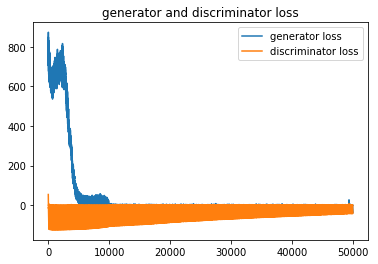

In [73]:
#training the GAN
import os
import pandas as pd
# from gan import GAN
import random
import tensorflow as tf

random.seed(42)
class TrainGan:

    def __init__(self, num_historical_days, batch_size=128):
        self.batch_size = batch_size
        self.data = []
#         files = [os.path.join('./stock_data', f) for f in os.listdir('./stock_data')]

        # Google Drive Method
        files = [f"{googlepath}stock_data/{f}" for f in os.listdir(f"{googlepath}stock_data")]
#         print(files)
      
        for file in files:
            print(file)
            #Read in file -- note that parse_dates will be need later
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df[['open','high','low','close','volume']]
            # #Create new index with missing days
            # idx = pd.date_range(df.index[-1], df.index[0])
            # #Reindex and fill the missing day with the value from the day before
            # df = df.reindex(idx, method='bfill').sort_index(ascending=False)
            #Normilize using a of size num_historical_days
            df = ((df -
            df.rolling(num_historical_days).mean().shift(-num_historical_days))
            /(df.rolling(num_historical_days).max().shift(-num_historical_days)
            -df.rolling(num_historical_days).min().shift(-num_historical_days)))
            #Drop the last 10 day that we don't have data for
            df = df.dropna()
            #Hold out the last year of trading for testing
            #Padding to keep labels from bleeding
            df = df[400:]
            #This may not create good samples if num_historical_days is a
            #mutliple of 7
            for i in range(num_historical_days, len(df), num_historical_days):
                self.data.append(df.values[i-num_historical_days:i])

        self.gan = GAN(num_features=5, num_historical_days=num_historical_days,
                        generator_input_size=200)

    def random_batch(self, batch_size=128):
        batch = []
        while True:
            batch.append(random.choice(self.data))
            if (len(batch) == batch_size):
                yield batch
                batch = []

    def train(self, print_steps=100, display_data=100, save_steps=SAVE_STEPS_AMOUNT):
        if not os.path.exists(f'{googlepath}models'):
            os.makedirs(f'{googlepath}models')
        sess = tf.Session()
        
        G_loss = 0
        D_loss = 0
        G_l2_loss = 0
        D_l2_loss = 0
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        currentStep = "0"
        
        g_loss_array = []
        d_loss_array = []
        
        if os.path.exists(f'{googlepath}models/checkpoint'):
                with open(f'{googlepath}models/checkpoint', 'rb') as f:
                    model_name = next(f).split('"'.encode())[1]
                filename = "{}models/{}".format(googlepath, model_name.decode())
                currentStep = filename.split("-")[1]
                new_saver = tf.train.import_meta_graph('{}.meta'.format(filename))
                new_saver.restore(sess, "{}".format(filename))

        for i, X in enumerate(self.random_batch(self.batch_size)):

            
            
            
            if i % 1 == 0:
                _, D_loss_curr, D_l2_loss_curr = sess.run([self.gan.D_solver, self.gan.D_loss, self.gan.D_l2_loss], feed_dict=
                        {self.gan.X:X, self.gan.Z:self.gan.sample_Z(self.batch_size, 200)})
                D_loss += D_loss_curr
                D_l2_loss += D_l2_loss_curr
            if i % 1 == 0:
                _, G_loss_curr, G_l2_loss_curr = sess.run([self.gan.G_solver, self.gan.G_loss, self.gan.G_l2_loss],
                        feed_dict={self.gan.Z:self.gan.sample_Z(self.batch_size, 200)})
                G_loss += G_loss_curr
                G_l2_loss += G_l2_loss_curr
                
            g_loss_array.append(G_loss_curr - G_l2_loss)
            d_loss_array.append(D_loss_curr - D_l2_loss)
            
            
            if (i+1) % print_steps == 0:
                print('Step={} D_loss={}, G_loss={}'.format(i + int(currentStep), D_loss/print_steps - D_l2_loss/print_steps, G_loss/print_steps - G_l2_loss/print_steps))
                #print('D_l2_loss = {} G_l2_loss={}'.format(D_l2_loss/print_steps, G_l2_loss/print_steps))
                G_loss = 0
                D_loss = 0
                G_l2_loss = 0
                D_l2_loss = 0
            if (i+1) % save_steps == 0:
                saver.save(sess, f'{googlepath}/models/gan.ckpt', i + int(currentStep))
            
            # end training at training_amount epochs
            if ((i + int(currentStep)) > TRAINING_AMOUNT):
                
                print("Reached {} epochs for GAN".format(i + int(currentStep)))
                sess.close()
                
                axisX = np.arange(0,len(g_loss_array),1)
                plt.plot(axisX, g_loss_array, label='generator loss')
                plt.plot(axisX, d_loss_array, label='discriminator loss')
                plt.legend()
                plt.title('generator and discriminator loss')
                plt.show()
                
                break

            # if (i+1) % display_data == 0:
            #     print('Generated Data')
            #     print(sess.run(self.gan.gen_data, feed_dict={self.gan.Z:self.gan.sample_Z(1, 200)}))
            #     print('Real Data')
            #     print(X[0])


# if __name__ == '__main__':
tf.reset_default_graph()
gan = TrainGan(HISTORICAL_DAYS_AMOUNT, 128)
gan.train()

In [0]:
#modeling CNN

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

SEED = 42
tf.set_random_seed(SEED)
class CNN():

    def __init__(self, num_features, num_historical_days, is_train=True):
      
        self.X = tf.placeholder(tf.float32, shape=[None, num_historical_days, num_features])
        X = tf.reshape(self.X, [-1, num_historical_days, 1, num_features])
        self.Y = tf.placeholder(tf.int32, shape=[None, 2])
        self.keep_prob = tf.placeholder(tf.float32, shape=[])

        with tf.variable_scope("cnn"):
            #[filter_height, filter_width, in_channels, out_channels]
            k1 = tf.Variable(tf.truncated_normal([3, 1, num_features, 16],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b1 = tf.Variable(tf.zeros([16], dtype=tf.float32))

            conv = tf.nn.conv2d(X,k1,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b1))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob = self.keep_prob)
            print(relu)


            k2 = tf.Variable(tf.truncated_normal([3, 1, 16, 32],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b2 = tf.Variable(tf.zeros([32], dtype=tf.float32))
            conv = tf.nn.conv2d(relu, k2,strides=[1, 1, 1, 1],padding='SAME')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b2))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob = self.keep_prob)
            print(relu)


            k3 = tf.Variable(tf.truncated_normal([3, 1, 32, 64],
                stddev=0.1,seed=SEED, dtype=tf.float32))
            b3 = tf.Variable(tf.zeros([64], dtype=tf.float32))
            conv = tf.nn.conv2d(relu, k3, strides=[1, 1, 1, 1], padding='VALID')
            relu = tf.nn.relu(tf.nn.bias_add(conv, b3))
            if is_train:
                relu = tf.nn.dropout(relu, keep_prob=self.keep_prob)
            print(relu)


            flattened_convolution_size = int(relu.shape[1]) * int(relu.shape[2]) * int(relu.shape[3])
            print(flattened_convolution_size)
            flattened_convolution = features = tf.reshape(relu, [-1, flattened_convolution_size])

            if is_train:
                flattened_convolution =  tf.nn.dropout(flattened_convolution, keep_prob=self.keep_prob)

            W1 = tf.Variable(tf.truncated_normal([18*1*64, 32]))
            b4 = tf.Variable(tf.truncated_normal([32]))
            h1 = tf.nn.relu(tf.matmul(flattened_convolution, W1) + b4)


            W2 = tf.Variable(tf.truncated_normal([32, 2]))
            logits = tf.matmul(h1, W2)

            #self.accuracy = tf.metrics.accuracy(tf.argmax(self.Y, 1), tf.argmax(logits, 1))
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(self.Y, 1), tf.argmax(logits, 1)), tf.float32))
            self.confusion_matrix = tf.confusion_matrix(tf.argmax(self.Y, 1), tf.argmax(logits, 1))
            tf.summary.scalar('accuracy', self.accuracy)
            theta_D = [k1, b1, k2, b2, k3, b3, W1, b4, W2]           
            
            # D_prob = tf.nn.sigmoid(D_logit)

        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.Y, logits=logits))
        tf.summary.scalar('loss', self.loss)
        # self.D_l2_loss = (0.0001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_D]) / len(theta_D))
        # self.D_loss = D_loss_real + D_loss_fake + self.D_l2_loss
        # self.G_l2_loss = (0.00001 * tf.add_n([tf.nn.l2_loss(t) for t in theta_G]) / len(theta_G))
        # self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake))) + self.G_l2_loss

        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(self.loss)
        self.summary = tf.summary.merge_all()


Tensor("cnn/Relu:0", shape=(?, 20, 1, 16), dtype=float32)
Tensor("cnn/Relu_1:0", shape=(?, 20, 1, 32), dtype=float32)
Tensor("cnn/Relu_2:0", shape=(?, 18, 1, 64), dtype=float32)
1152
/content/drive/My Drive/Colab Notebooks/SeniorDesignGAN/MiloGAN/stock_data/AMZN.csv
/content/drive/My Drive/Colab Notebooks/SeniorDesignGAN/MiloGAN/stock_data/AAPL.csv
Step=99 loss=0.6808989128470421, accuracy=0.674609375
Test loss = 0.5638794302940369, Test accuracy = 0.7217391133308411
Step=199 loss=0.40181615978479385, accuracy=0.829453125
Test loss = 0.49724796414375305, Test accuracy = 0.769565224647522
Step=299 loss=0.3034666983783245, accuracy=0.90078125
Test loss = 0.4646162688732147, Test accuracy = 0.7797101736068726
Step=399 loss=0.24045984357595443, accuracy=0.93921875
Test loss = 0.4684075713157654, Test accuracy = 0.7927536368370056
Step=499 loss=0.19585732519626617, accuracy=0.95234375
Test loss = 0.47597217559814453, Test accuracy = 0.7840579748153687
Step=599 loss=0.15732933893799783, accu

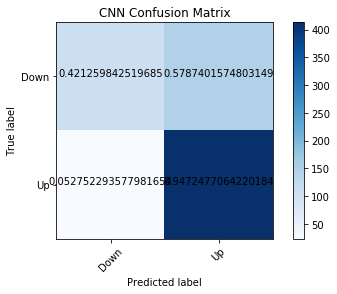

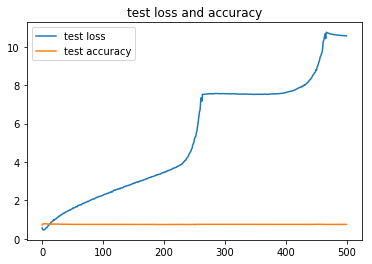

In [75]:
#training CNN

import os
import pandas as pd
# from cnn import CNN
import random
import tensorflow as tf
import xgboost as xgb
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
# from plot_confusion_matrix import plot_confusion_matrix

random.seed(42)

class TrainCNN:

    def __init__(self, num_historical_days, days=10, pct_change=0):
        self.data = []
        self.labels = []
        self.test_data = []
        self.test_labels = []
        self.cnn = CNN(num_features=5, num_historical_days=num_historical_days, is_train=False)
#         files = [os.path.join('./stock_data', f) for f in os.listdir('./stock_data')]

        # Google Drive Method
        files = [f"{googlepath}stock_data/{f}" for f in os.listdir(f"{googlepath}stock_data")]
#         print(files)
    
    
        for file in files:
            print(file)
            df = pd.read_csv(file, index_col='timestamp', parse_dates=True)
            df = df[['open','high','low','close','volume']]
            # data for new column labels that will use the pct_change of the closing data.
            # pct_change measure change between current and prior element. Map these into a 1x2
            # array to show if the pct_change > (our desired threshold) or less than.
            labels = df.close.pct_change(days).map(lambda x: [int(x > pct_change/100.0), int(x <= pct_change/100.0)])
            
            # rolling normalization. (df - df.mean) / (df.max - df.min)
            df = ((df -
            df.rolling(num_historical_days).mean().shift(-num_historical_days))
            /(df.rolling(num_historical_days).max().shift(-num_historical_days)
            -df.rolling(num_historical_days).min().shift(-num_historical_days)))
            df['labels'] = labels

            # doing pct_change will give some rows (like first row) a NaN value. Drop that.
            df = df.dropna()

            # Do the testing data split
            test_df = df[:365]
            df = df[400:]

            # get the predictors of the dataframe
            data = df[['open','high','low','close','volume']].values

            # the response value
            labels = df['labels'].values

            # start at num_historical_days and iterate the full length of the training
            # data at intervals of num_historical_days
            for i in range(num_historical_days, len(df), num_historical_days):
                # split the df into arrays of length num_historical_days and append
                # to data, i.e. array of df[curr - num_days : curr] -> a batch of values
                self.data.append(data[i-num_historical_days:i])

                # appending if price went up or down in curr day of "i" we are looking
                # at
                self.labels.append(labels[i-1])
            
            # do same for test data
            data = test_df[['open','high','low','close','volume']].values
            labels = test_df['labels'].values
            for i in range(num_historical_days, len(test_df), 1):
                self.test_data.append(data[i-num_historical_days:i])
                self.test_labels.append(labels[i-1])

    # a function to get a random_batch of data.
    def random_batch(self, batch_size=128):
        batch = []
        labels = []
        # zip concatenates each array index of both arrays together
        data = list(zip(self.data, self.labels))
        i = 0
        while True:
            i+= 1
            while True:
                # pick a random array, i.e. range of days, from data
                d = random.choice(data)
                # balance the data with equal number of positive pct_change
                # and negative pct_change
                if(d[1][0]== int(i%2)):
                    break
            batch.append(d[0])  # append the range of days we got to batch
            labels.append(d[1])  # append the label of that range of data we got
            if (len(batch) == batch_size):
                yield batch, labels
                batch = []
                labels = []

    def train(self, print_steps=100, display_steps=100, save_steps=SAVE_STEPS_AMOUNT, batch_size=128, keep_prob=0.6):
        if not os.path.exists(f'{googlepath}cnn_models'):
            os.makedirs(f'{googlepath}cnn_models')
        if not os.path.exists(f'{googlepath}logs'):
            os.makedirs(f'{googlepath}logs')
        if os.path.exists(f'{googlepath}logs/train'):
            for file in [os.path.join(f'{googlepath}logs/train/', f) for f in os.listdir(f'{googlepath}logs/train/')]:
                os.remove(file)
        if os.path.exists(f'{googlepath}logs/test'):
            for file in [os.path.join(f'{googlepath}logs/test/', f) for f in os.listdir(f'{googlepath}logs/test')]:
                os.remove(file)

        sess = tf.Session()
        loss = 0
        l2_loss = 0
        accuracy = 0
        saver = tf.train.Saver()
        train_writer = tf.summary.FileWriter(f'{googlepath}/logs/train')
        test_writer = tf.summary.FileWriter(f'{googlepath}/logs/test')
        sess.run(tf.global_variables_initializer())
        
        test_loss_array = []
        test_accuracy_array = []
        currentStep = "0"
        
        if os.path.exists(f'{googlepath}cnn_models/checkpoint'):
                with open(f'{googlepath}cnn_models/checkpoint', 'rb') as f:
                    model_name = next(f).split('"'.encode())[1]
                filename = "{}cnn_models/{}".format(googlepath, model_name.decode())
                currentStep = filename.split("-")[1]
                new_saver = tf.train.import_meta_graph('{}.meta'.format(filename))
                new_saver.restore(sess, "{}".format(filename))

        for i, [X, y] in enumerate(self.random_batch(batch_size)):

          
            _, loss_curr, accuracy_curr = sess.run([self.cnn.optimizer, self.cnn.loss, self.cnn.accuracy], feed_dict=
                    {self.cnn.X:X, self.cnn.Y:y, self.cnn.keep_prob:keep_prob})
            loss += loss_curr
            accuracy += accuracy_curr
            if (i+1) % print_steps == 0:
                print('Step={} loss={}, accuracy={}'.format(i + int(currentStep), loss/print_steps, accuracy/print_steps))
                loss = 0
                l2_loss = 0
                accuracy = 0
                test_loss, test_accuracy, confusion_matrix = sess.run([self.cnn.loss, self.cnn.accuracy, self.cnn.confusion_matrix], feed_dict={self.cnn.X:self.test_data, self.cnn.Y:self.test_labels, self.cnn.keep_prob:1})
                test_loss_array.append(test_loss)
                test_accuracy_array.append(test_accuracy)
                print("Test loss = {}, Test accuracy = {}".format(test_loss, test_accuracy))
            if (i+1) % save_steps == 0:
                saver.save(sess,  f'{googlepath}cnn_models/cnn.ckpt', i)

            if (i+1) % display_steps == 0:
                summary = sess.run(self.cnn.summary, feed_dict=
                    {self.cnn.X:X, self.cnn.Y:y, self.cnn.keep_prob:keep_prob})
                train_writer.add_summary(summary, i)
                summary = sess.run(self.cnn.summary, feed_dict={
                    self.cnn.X:self.test_data, self.cnn.Y:self.test_labels, self.cnn.keep_prob:1})
                test_writer.add_summary(summary, i)
            
            # end training at training_amount epochs
            if (i + int(currentStep)) > TRAINING_AMOUNT:
                print("Reached {} epochs for CNN".format(i + int(currentStep)))
                sess.close()
                print(confusion_matrix)
                plot_confusion_matrix(confusion_matrix, ['Down', 'Up'], normalize=True, title="CNN Confusion Matrix")
                
                axisA = np.arange(0,len(test_loss_array),1)
                axisB = np.arange(0,len(test_accuracy_array),1)
                plt.plot(axisA, test_loss_array, label='test loss')
                plt.plot(axisB, test_accuracy_array, label='test accuracy')
                plt.legend()
                plt.title('test loss and accuracy')
                plt.show()

                break


# if __name__ == '__main__':
tf.reset_default_graph()
cnn = TrainCNN(num_historical_days=HISTORICAL_DAYS_AMOUNT, days=DAYS_AHEAD, pct_change=PCT_CHANGE_AMOUNT)
cnn.train()

